In [21]:
import re
import random
import pandas as pd
import hashlib

In [22]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [23]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Jane Eyre, Bronte",85.136930,10.642116,19.649905,8
Azure Functions + Visual Studio,179.392080,59.797360,137.724220,3
Azure AD Authentication,428.087100,35.673925,106.781148,12
Email Auth and Security,441.460157,55.182520,131.449206,8
Logging in Python,444.307593,31.736257,74.319258,14
RAG Project,776.053602,77.605360,221.129559,10
Debugging in VS Code,893.383625,81.216693,210.543738,11
Azure Private DNS,942.551674,49.607983,121.386494,19
C# Basics,1083.645093,34.956293,105.247111,31
Azure Functions + PP365,1399.096082,66.623623,193.585824,21


# Histogram

sum of ages: ~34465.90


<Axes: >

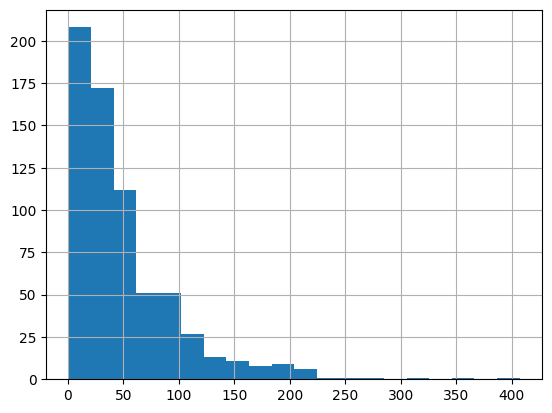

In [24]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~34465.90


<Axes: >

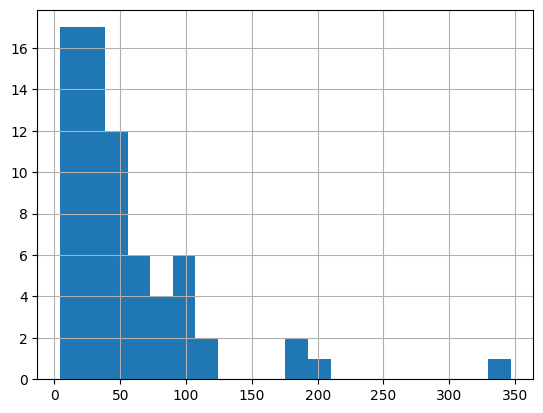

In [25]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [26]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [27]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [28]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [29]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [30]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [31]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [32]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [33]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 674
Total card age: 34465.90


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
16,Azure Developer Associate,Which role grants least privilege to allow a u...,72ce544617e81069d717793d0c83d443,-346.839351,55.049826,346.839351,-3743.38819,0.262882,0,0
17,Azure Developer Associate,How do you set a 10-second expiration on a Red...,2c0a47d0832a06066815e587aa865366,-189.149868,55.049826,346.839351,-3743.38819,0.262882,3,0
18,Azure Developer Associate,You can pull container images from Azure Conta...,d3c3fa54b8227ecfb15e18b69bf5afa3,-106.051516,55.049826,346.839351,-3743.38819,0.262882,6,0
19,Azure Developer Associate,You plan to develop an Azure App Service web a...,30469091eba15f09be82d06129ecd78e,-95.038556,55.049826,346.839351,-3743.38819,0.262882,9,0
20,Azure Developer Associate,You develop an App Service app hosted on Windo...,9d27bc69ef8320363df96f1ca52b799e,-87.745071,55.049826,346.839351,-3743.38819,0.262882,12,0
21,Azure Developer Associate,Type of Azure Container Registry authenticatio...,479458e1b339f5153c380c9b5d3d9922,-73.483608,55.049826,346.839351,-3743.38819,0.262882,15,0
481,Azure Developer Associate,The code segment acr repository delete --name ...,3e0c920bbcca10037612214b9300db45,-58.238207,55.049826,346.839351,-3743.38819,0.262882,18,0
25,Azure Developer Associate,What Azure CLI command allows CORS from https:...,95d2a75240a646635b69d89fe62896ef,-57.019265,55.049826,346.839351,-3743.38819,0.262882,21,0
480,Azure Developer Associate,Make sure you add the period (.) to the end of...,dcd2a6970dcd4fd13e31426277eccd8b,-54.387124,55.049826,346.839351,-3743.38819,0.262882,24,0
257,Azure Developer Associate,Geo-replication enables a container registry t...,bc0e2da023ab89eb21878030f1e01e8a,-51.675740,55.049826,346.839351,-3743.38819,0.262882,27,0


## Age Mean

In [34]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [35]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [36]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [37]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [38]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Asynchronous Python,Awaitable\nAny object in Python that can be us...,56b47f1b55955533a2140918db6d5be0,-407.040281,68.279559,407.040281,-3140.859713,0.334512,0,0
16,Azure Developer Associate,Which role grants least privilege to allow a u...,72ce544617e81069d717793d0c83d443,-346.839351,55.049826,346.839351,-3743.388190,0.262882,0,0
39,PowerShell Modules,Module Scope Management\n\nDefinition: Control...,2ebf820a231a01c49801fca43af0a504,-318.146090,69.209196,318.146090,-2560.740263,0.996709,0,0
52,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,-284.430142,59.173939,284.430142,-1420.174530,0.366274,0,0
60,Python,Q:\nExplain how itertools.combinations() diffe...,80f75640c457518dd98fc05f857164dd,-249.125390,72.995825,249.125390,-2335.866402,0.104023,0,0
71,PnP PowerShell,Set-PnPList (PnP.PowerShell)\nModifies propert...,ec61ff7f95b8fe03595feae81fd53798,-233.677100,46.816918,233.677100,-2574.930483,0.146883,0,0
90,RAG Project,Factory Function (create_app)\nA function that...,b8e2a1f3abaa53ee84f1f660c74697fe,-221.129559,77.605360,221.129559,-776.053602,0.321646,0,0
94,Azure DevOps Pipelines,What is the purpose of the dependsOn keyword i...,f9b3e3c17611e6887301f5a1aff352b3,-217.518010,61.646643,217.518010,-1602.812712,0.658380,0,0
321,RAG Project,pytest.mark.asyncio\nA decorator that marks a ...,b5113e6bd7ecba984bd0fc0ede2f0238,-213.053263,77.605360,221.129559,-776.053602,0.321646,1,1
107,JavaScript Concepts,"Heroku: A cloud platform for deploying, managi...",81c33c8653348fa2529f220a4a2e60b1,-211.059362,55.909817,211.059362,-2292.302516,0.809270,0,0


In [39]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   Which role grants least privilege to allow a u...
hash                   72ce544617e81069d717793d0c83d4432c0a47d0832a06...
age                                                         -1119.628307
subject_mean_age                                              550.498263
subject_highest_age                                          3468.393514
subject_age_sum                                            -37433.881905
head_random_roll                                                2.628817
count                                                                135
n_fold                                                                 0
dtype: object

In [40]:
existing_cards['age'].mean()

-51.13634401328086